# Chapter 17 - Model Selection and Cross Validation

In machine learning, making fewer assummptions and restrictions means that we have many options for choosing and adapting models. One important part of machine learning is therefore to select the models and how to tune them so that we get good generalization.  

Model selection is about finding a model that will give good predictions for new data from the same underlying distribution. It can also be about reflecting the process that we are modelling, but that is usually less of a focus in machine learning. The underlying distribution is usually unknown, and without making assumptions we can only use the empirical approach introduced in the previous chapter. 

There are several ways to select among the vast number of choices for models and for evaluating their performance. Machine learning is often formulated as some form of optimization, i.e. minimising an error metric or maximizing likelyhood. The optimization process can be a closed form clacuation (linear regression), an iterative algorithm (logistic regression), or be a search process (decision tree splits). 

It is important, however, that the quantity we are ultimately interested in - the prediction quality on unseen data - is by definition not directly available to an optimisation procedure. We therefore need to set up specific approaches to the model optimisation and selection processes to make sure we optimise for the right target. 

## Model Selection

In machine learning we fit models to training data, but since the goal is to have good predictions for new input data, the performance on the training data is not a good indicator of model quality. Therefore we held out part of the available data as a test dataset. 

There are sometime cases, we have an effectively infinite supply of labelled data (e.g. text on the internet). However, in most cases, labelled data is not easy to obtain and we need to make the most of the data we have. 
We will look at two different models and how to determin which one is more suitable for a problem.   

### Digits Dataset
This time we will look at a different, but also well known, dataset containing information about hand-written digits. It contains 8x8 = 64 pixel brightness values (0...16) as features and 10 different digits as classes. See https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits for more information.

In [193]:
from sklearn.datasets import load_digits, load_wine
dataset = load_wine()
#dataset = load_digits()
# print(dataset.keys()) # available elements
print(len(dataset.target)) # no of samples

X = dataset.data
y = dataset.target

178


In [202]:

from sklearn.model_selection import train_test_split
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=seed)


### Another Classifier - Nearest Neighbor

We now use another classifier: the K-Nearest--Neighbor (KNN) classifier. This classifier is very simple: is views the feature values of an item as a vectors. For a new feature vector, we calculate the $k$ closest feature vectors in our training set. We then look up the classes belonging to these $k$ feature vectors and choose the most frequent one as our KNN prediction. The number $k$ determines the behaviour. In the simplest case we can choose $1$, which makes it easy to select the predicted class (no ties). This is a very simple classifier, but it can be quite effective. 

Our question now is, whether to use KNN or a Decision Tree (DT) classifier. We start by training both models on our training set and calculate the performance on the test set. 

In [203]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# train both classifiers
dtc = DecisionTreeClassifier(max_depth=5,random_state=0)
dtc.fit(X_train,y_train)

#knn = KNeighborsClassifier(n_neighbors=1)
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

# helper functions to calculate the accuracy values on train, validation and test set. 
def accuracy(X,y,predictor):
    return np.sum(np.equal(predictor.predict(X),y))/len(X)

def trainValTestAcc(predictor):
    vals = {}
    vals['train'] = accuracy(X_train,y_train,predictor)
    vals['test'] = accuracy(X_test,y_test,predictor)
    return vals

print(" DT: ",trainValTestAcc(dtc))
print("KNN: ",trainValTestAcc(knn))

 DT:  {'train': 1.0, 'test': 0.9722222222222222}
KNN:  {'train': 0.7887323943661971, 'test': 0.8055555555555556}


We see athat DT seems to work better than KNN on the test set. However, this is just on the 20\% of the data our test set. In order to test whether data selection is the cause of the difference, we can look at different ways to split the data by changing the value of the `seed` variable above. That has the effecto of changing re results of train_test split. You can try it our for yourself with the notebooks provided with this book, but here are some results to study.

`
seed = 1
 DT:  {'train': 0.9295774647887324, 'test': 0.8611111111111112}
KNN:  {'train': 1.0, 'test': 0.75}
seed = 2
 DT:  {'train': 0.9295774647887324, 'test': 0.9166666666666666}
KNN:  {'train': 1.0, 'test': 0.7222222222222222}
seed = 3
 DT:  {'train': 0.9436619718309859, 'test': 0.7777777777777778}
KNN:  {'train': 1.0, 'test': 0.6666666666666666}
seed = 4
 DT:  {'train': 0.9295774647887324, 'test': 0.8888888888888888}
KNN:  {'train': 1.0, 'test': 0.8333333333333334}
seed = 5
 DT:  {'train': 0.9366197183098591, 'test': 0.7222222222222222}
KNN:  {'train': 1.0, 'test': 0.75}
`

In most cases, the KNN produces higher accuracy, but in the last one the DT is better. We can also see that there is significant variation between the different splits that we created by using different seeds. The question we need to answer now, is whether the better performance of the DT is due to the underlying process, i.e. the true distribution of model performances on data from underlying distribution, or whether it is likely be the result of random variation. To gain some evidence we need two things: more measurements and a statistical test. 

## Cross-Validation

The measurements we are taking are based on randomly selected training and test splits. As we increase the number of splits to test, we will increasligly have overlap between them, because the same datapoints will be reused. To obtain multiple independent test datasets, we would ideally use newly collected data. However, getting more data is often not feasible. A method to make most use of small datasets is called **Cross Validation**. The idea of cross validation is to divide the data systematically such that each data item is used only in one test set. 

The most common type is **k-Fold Cross-Validation**, where we divide the whole dataset into $k$ subsets (folds) of approximately equal size. Each fold is used once used as the test set, while the remaining $k-1$ are used as the training set. In this way we get $k$ different samples of the performance. Commonly used values for $k$ are between $4$ and $10$. In the extreme case of $k = n$, where $n$ is the size of the dataset, it is called **leave-one-out cross-validation**.

There are ready-made implementations of k-fold cross available. 

[In Scikit-Learn, there KFold class works similar to `train_test_split`, but it generates $k$ splits. `KFold.split()` generates indices that we can use to]: # 

The function `cross_validate` is available in Scikit-Learn and makes it easy to use cross valiadation. It is left as an exercise to implement your own version of `cross_validate` (see below).

In [214]:
from sklearn.model_selection import cross_validate, KFold, LeaveOneOut

cv = KFold(10)
scores = cross_validate(knn,X,y,cv=cv,scoring='accuracy',return_train_score=True)
print('10-fold CV, train accuracy, mean: ',scores['train_score'].mean(),', std dev:',scores['train_score'].std())
print('10-fold CV, test accuracy, mean: ',scores['test_score'].mean(),', std dev:',scores['test_score'].std())

cv = KFold(20)
scores = cross_validate(knn,X,y,cv=cv,scoring='accuracy',return_train_score=True)
print('20-fold CV, train accuracy, mean: ',scores['train_score'].mean(),', std dev:',scores['train_score'].std())
print('20-fold CV, test accuracy, mean: ',scores['test_score'].mean(),', std dev:',scores['test_score'].std())

cv = LeaveOneOut()
scores = cross_validate(knn,X,y,cv=cv,scoring='accuracy')
print('Leave-one-out, test accuracy, mean: ',scores['test_score'].mean(),
      ', std dev:',scores['test_score'].std())

10-fold CV, train accuracy, mean:  0.7908773291925465 , std dev: 0.014431536173722965
10-fold CV, test accuracy, mean:  0.6310457516339869 , std dev: 0.21593098615373252
20-fold CV, train accuracy, mean:  0.7868203967977725 , std dev: 0.014300505928935777
20-fold CV, test accuracy, mean:  0.6590277777777779 , std dev: 0.23288129990550768
Leave-one-out, test accuracy, mean:  0.6966292134831461 , std dev: 0.45971398978604006


We can observe that that leave-one-out CV produces higher standard deviation, as to be expected from smaller test sets. When the code is run, we can see that the leave-one-out CV takes longer, because it has to train and test $n = 178$ times, while the k-fold CV only has $k = 10$ iterations.  

We also see that the leave-on-out CV produces higher accuracy results. There are two contributing factors here, the larger size of the training set ($n-1$ vs $0.8 n$) and avoiding of class imbalances in the test sets. When taking a random samples, we will get variation in the distribution of classes between the folds. This can skew the accuracy measurements, because the some classes may be harder to predict than others and because the class distribution between the training and test set can be different.  

We can ensure that the class distribution in all folds is approximately the same, which is called stratified sampling and leads to **Stratified Cross Validation**. This is implemented in Scikit-Learn as `StratifiedKFold`  and can be used exactly as `KFold`.

In [215]:
from sklearn.model_selection import StratifiedKFold, LeaveOneOut

cv = StratifiedKFold(10,shuffle=True,random_state=0)
scores = cross_validate(knn,X,y,cv=cv,scoring='accuracy')
print('10-fold Stratifed CV, test accuracy, mean: ',scores['test_score'].mean(),
      ', std dev:',scores['test_score'].std())

10-fold Stratifed CV, test accuracy, mean:  0.6748366013071896 , std dev: 0.06665785537054658


We observe that standard deviation of the test accuracy is lower with stratified sampling, as expected because of the more stable classs distribution. We also see an increased accuracy, almost as high as with the leave-one-out CV, which indicates that the effect of the class imbalance was stronger than that of the smaller training sets when comparing k-fold to leave-one-out CV.

### Significance of Model Differences

When trying to assess whether on ML model is better we can use CV (or multiple datasets) to create mulitple independent measurements and test for for significance of their difference. Given that we have no good reasons to assume normality of the distribution of the accuracy values, it is safest to use a non-parametric test. In chapter 9. The Wilcoxon signed-rank test tests for sginificantly different medians. Alternatively, a pairwise t-test could be used, but normality of the distribtion should be tested beforehand. Normality can normally not not be shown, at least for smaller datasets. 

We will now apply both KNN and DT and apply the Wilcoxong test to the test accuracy results per fold. The p-value gives the probability that a difference between the models of this size or more could have been observed when the underlying distribution had the same median. We normally accept the models as being different when the p-value is below 5%. For significance tests, it is better to have more independent measurements. We can therefore increas the number of folds, as the resulting smaller test sets do not increas the variation between measurements too much, as happened in the leave-one-out CV above. A value of 20 seems like a good guess, as it still leaves ~35 samples in every fold.

In [216]:
cv = KFold(20)

scores_knn = cross_validate(knn,X,y,cv=cv,scoring='accuracy')
scores_dtc = cross_validate(dtc,X,y,cv=cv,scoring='accuracy')
print('avg accuracy KNN:',scores_knn['test_score'].mean(),', DT: ',scores_dtc['test_score'].mean())
print('avg accuracy KNN std:',scores_knn['test_score'].std(),', DT: ',scores_dtc['test_score'].std())
#print(scores_knn['test_score']-scores_dtc['test_score'])

from scipy.stats import wilcoxon 
wilcoxon(scores_dtc['test_score'],scores_knn['test_score'], mode='approx')

avg accuracy KNN: 0.6590277777777779 , DT:  0.8777777777777779
avg accuracy KNN std: 0.23288129990550768 , DT:  0.1401057801435388


WilcoxonResult(statistic=6.0, pvalue=0.003074168162550741)

The results show that the difference is significant, i.e. the KNN is significantly better than the DT model at predicting Wine type from the chemical measurements. We can also test whether Stratified CV leads to a less variation (stdandard deviation) and better accuracy.

In [217]:
cv = StratifiedKFold(20)
#cv = StratifiedKFold(10,shuffle=True,random_state=6)

scores_knn = cross_validate(knn,X,y,cv=cv,scoring='accuracy')
scores_dtc = cross_validate(dtc,X,y,cv=cv,scoring='accuracy')
print('avg accuracy KNN mean:',scores_knn['test_score'].mean(),', DT: ',scores_dtc['test_score'].mean())
print('avg accuracy KNN std:',scores_knn['test_score'].std(),', DT: ',scores_dtc['test_score'].std())
#print(scores_knn['test_score']-scores_dtc['test_score'])

from scipy.stats import wilcoxon 
import scipy
wilcoxon(scores_dtc['test_score'],scores_knn['test_score'],mode='approx')

avg accuracy KNN mean: 0.7041666666666667 , DT:  0.9111111111111111
avg accuracy KNN std: 0.13088758016700938 , DT:  0.11439589045541111


WilcoxonResult(statistic=12.0, pvalue=0.0004792877798731423)

As we can see, all effects of Stratified CV occur: lower standard deviation, higher accuracy and lower p-value, i.e. a more significant result. 

### Hyper-parameter Tuning

In addition to selecting a model-type, we also need to set values that control the training process, e.g. regularization parameters, or the size and structure of the model (e.g. the maximal deth of a decision tree).  The settings are usually called hyper-parameters to distinguish them from the parameters within a model that are optimized during training (e.g. the feature thresholds in a decision tree). 

The approach is very similar to model selection, we can indeed view models with different hyper-parameters as different models and apply the same technique. In practice, however, the tuning of hyper-parameters and the selection of a models type are treated separately because the implementation is easier, and then compared after optimization.

A very commmon hyper-parameter is the regularization as we saw in the last chapter. We can tune regularisation testing several parameter values and selecting the one that creates best value in CV. It is often informative, to view the performance on for different hyper-parameter values for different performance. This whole process is availabe in a single function in Scikit-Learn called `validation_cureve`. It takes an a model and 

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.64607843 0.82058824 0.90457516 0.89346405 0.89901961 0.89346405
 0.89346405 0.89346405 0.89346405]
3


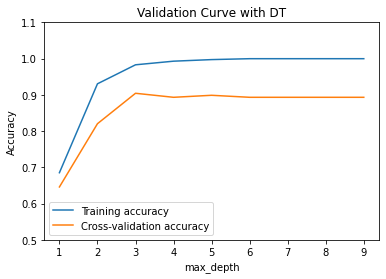

In [224]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

cv = StratifiedKFold(10,shuffle=True,random_state=1)

param_range = list(range(1, 10))
print(param_range)

train_scores, test_scores = validation_curve( dtc, X, y, cv=cv,
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy"
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
print(test_scores_mean)
print(np.argmax(test_scores_mean)+1) # best hyper--param value

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.1)

plt.plot(
    param_range, train_scores_mean, label="Training accuracy"
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation accuracy"
)
plt.legend(loc="best")
plt.show()

The curve shows us that the training accuracy keeps increasing as we allow deeper decision trees. 
However, the cross-validation accuracy reaches a peak at a depth of $3$ and then decreases. The best value for `max_depth` for a decision tree on this dataset is therefore $3$.

We could go even further in estimating the max_depth by applying the HP to the k training sets in a k-fold cross-validation (this is called **nested cross-validation**). This would however multiply the effort needed to optimise the parameter by the factor $k$. Whether this is worth doing in practice, depends on how critical the model performance is in the application scenario. Generally, there is a trade-off between making the most of a limited dataset and the computational cost to so. If the performance is very important, it is in practice often the better option to collect more trining data, as this is more effective in increasing performance without excessive additional computation.  

### Estimating the Model Performance

The evaluation of a ML model should include an estimate of the performance on new data. 
In order to get an unbiased estimate, the data we use to estimate model performance on new data is actually new to the model. 

That means that any information be used to in the evaluation cannot be used to optimise or select our model. 
This applies to training, model selection and hyperparameter tuning, following the principle of division into trainng and test data. 
Thererfore we need to take a test set (often called a held-out set) of data, that is not used in training, tuning or selection of models. The hyper-parameter tuning and the selection of the best model is then done using the separate set (taking out of the training set, if no new data are available), which is called the validation set. 

[0.6830985915492958, 0.9084507042253521, 0.9577464788732394, 0.9929577464788732, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5555555555555556, 0.75, 0.8055555555555556, 0.9722222222222222, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444]
4


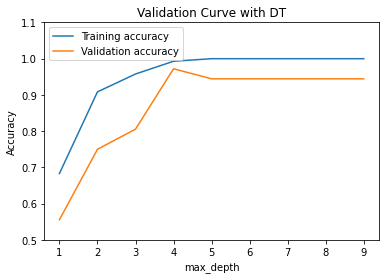

In [225]:
X_train2, X_val, y_train2, y_val = train_test_split(X,y,test_size=0.2,random_state=seed,stratify=y)

train_scores = []; val_scores = []
for md in param_range:
    dtc.max_depth = md
    dtc.fit(X_train2,y_train2)
    train_scores.append(np.sum(np.equal(dtc.predict(X_train2),y_train2))/len(y_train2))
    val_scores.append(np.sum(np.equal(dtc.predict(X_val),y_val))/len(y_val))

print(train_scores)    
print(val_scores)
print(np.argmax(val_scores)+1) # best hyper-param value

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.1)

plt.plot(
    param_range, train_scores, label="Training accuracy"
)
plt.plot(
    param_range, val_scores, label="Validation accuracy"
)
plt.legend(loc="best")
plt.show()

We see that the curve is less stable, because is bease only on one validation set. 
The best HP value is also different at $4$. 
Instead of usnig a single validation set, we can use CV or on the training set, as we did before on the whole set. 

[0.64476501 0.94365773 0.99295645 1.         1.         1.
 1.         1.         1.        ]
[0.62047619 0.91571429 0.93       0.93       0.93       0.93
 0.93       0.93       0.93      ]
3


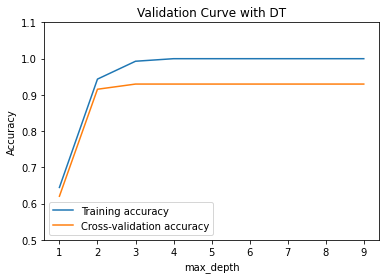

In [226]:
cv = StratifiedKFold(10,shuffle=True,random_state=1)
train_scores, test_scores = validation_curve( dtc, X_train, y_train,cv=cv,
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy"
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
print(train_scores_mean)
print(test_scores_mean)
print(np.argmax(test_scores_mean)+1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.1)

plt.plot(
    param_range, train_scores_mean, label="Training accuracy"
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation accuracy"
)
plt.legend(loc="best")
plt.show()

With CV on the training set, the curve of the validation accuracy is visually more similar to that on the whole set and the best HP value is now the same was we had with CV on the whole set. 
This illustrates that we can achieve mmore reliable results when using CV instead of a single split. 
With that HP value, we can now fit to the whole training set and estimate the accuracy on the test set. 

In [227]:
dtc.max_depth = 3
dtc.fit(X_train,y_train)
np.sum(np.equal(dtc.predict(X_test),y_test))/len(y_test)

0.9722222222222222

This estimate, seems overoptimistic, as it is better than the cross-validation accuracy. We can again improve reliability by applying cross validation. In this case, we actually had calculated that value above (under Hyper-parameter optimization), but at that point we couldn't be sure that the choice of hyper-parameter, and thus the accuracy estimate, was not too optimistic as it was obtained by optimizing to the training set. By also calculating the standard deviation over the folds, we can also assess the reliablity of this estimate. 

In [231]:
dtc.max_depth = 3
from sklearn.model_selection import cross_val_score
test_score = cross_val_score(dtc,X,y,cv=cv)
print("CV test accuracy mean: ",np.mean(test_score),", std: ",np.std(test_score))

CV test accuracy mean:  0.9045751633986928 , std:  0.04339888967590594


By tuning the hyper-parameter max_depth on data that is independent of the final test, we can be confident that we have not introduced selection bias in the process. There may still be noise in the estimate, but we reduced that with cross-validation in both the HP tuning and the final estimation, which also gives us a measure. Therefore we can be confident that this level of accuracy is realistic for data from the same distribution. 

## Summary



Overall, we found that a decision tree is better suited for the wine dataset. We can use a significance test on the differences between models in cross validation results to select the best model type. We can apply the same approach to optimize hyper-paramters. By keeping a hold-out set, we can get an unbiased estimate of the hyper-parameter and subsequently the model performance on new data. 

## Exercises

1. Implement the model selection and HP tuning as above for the iris dataset 
    a. vary the n_neighbors parameter for KNN, 
    b. plot the validation curve 
2. Implement nested cross-validation for tuning the max_depth of the decision tree on wine dataset. 
3. Implement a validation curve plot that shows the accuracies plus and minus the standard deviation. 

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier


# # train 3 classifiers
# lgr = LogisticRegression()
# lgr.fit(X_train_scl, y_train)

# dtc = DecisionTreeClassifier(max_depth=2,random_state=0)
# dtc.fit(X_train_scl,y_train)

# knn = KNeighborsClassifier()
# knn.fit(X_train_scl,y_train)

# # helper functions to calculate the accuracy values on train, validation and test set. 
# def accuracy(X,y,predictor):
#     return np.sum(np.equal(predictor.predict(X),y))/len(X)

# def trainValTestAcc(predictor):
#     vals = {}
#     vals['train'] = accuracy(X_train_scl,y_train,predictor)
#     vals['val'] = accuracy(X_val_scl,y_val,predictor)
#     vals['test'] = accuracy(X_test_scl,y_test,predictor)
#     return vals

# #print("logistic regression: ",trainValTestAcc(lgr))
# print("decision tree: ",trainValTestAcc(dtc))
# print("KNN: ",trainValTestAcc(knn))



# from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut

# k = 10 # 10-fold cross-validation
# #kf = KFold(n_splits=k,shuffle=True,random_state=0)
# kf = StratifiedKFold(n_splits=k,shuffle=True,random_state=0)
# #kf = RepeatedStratifiedKFold(n_splits=k, n_repeats=10, random_state=0)
# #kf = LeaveOneOut()

# knn_test_acc = []
# for train,test in kf.split(X,y):
#     knn.fit(X[train],y[train])
#     knn_test_acc.append(np.sum(np.equal(knn.predict(X[test]),y[test]))/len(y[test]))
# #print(knn_test_acc)
# print(np.mean(knn_test_acc))

# dtc_test_acc = []
# for train,test in kf.split(X,y):
#     dtc.fit(X[train],y[train])
#     dtc_test_acc.append(np.sum(np.equal(dtc.predict(X[test]),y[test]))/len(y[test]))   
# #print(dtc_test_acc)
# print(np.mean(dtc_test_acc))